In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls gdrive/MyDrive/ | grep Dataset.zip

In [3]:
!mkdir -pv content/sample_data/

mkdir: created directory 'content'
mkdir: created directory 'content/sample_data/'


In [4]:
!cp gdrive/MyDrive/Colab_Notebooks/ACML_Project/Dataset.zip content/sample_data/

In [5]:
!unzip content/sample_data/Dataset.zip

Archive:  content/sample_data/Dataset.zip
   creating: Dataset/glioma_tumor/
  inflating: Dataset/glioma_tumor/gg (1).jpg  
  inflating: Dataset/glioma_tumor/gg (10).jpg  
  inflating: Dataset/glioma_tumor/gg (100).jpg  
  inflating: Dataset/glioma_tumor/gg (101).jpg  
  inflating: Dataset/glioma_tumor/gg (102).jpg  
  inflating: Dataset/glioma_tumor/gg (103).jpg  
  inflating: Dataset/glioma_tumor/gg (104).jpg  
  inflating: Dataset/glioma_tumor/gg (105).jpg  
  inflating: Dataset/glioma_tumor/gg (106).jpg  
  inflating: Dataset/glioma_tumor/gg (107).jpg  
  inflating: Dataset/glioma_tumor/gg (108).jpg  
  inflating: Dataset/glioma_tumor/gg (109).jpg  
  inflating: Dataset/glioma_tumor/gg (11).jpg  
  inflating: Dataset/glioma_tumor/gg (110).jpg  
  inflating: Dataset/glioma_tumor/gg (111).jpg  
  inflating: Dataset/glioma_tumor/gg (112).jpg  
  inflating: Dataset/glioma_tumor/gg (113).jpg  
  inflating: Dataset/glioma_tumor/gg (114).jpg  
  inflating: Dataset/glioma_tumor/gg (115).jp

In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
# Importing Libraries
import numpy as np
import cv2
import os
import imutils

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from PIL import Image


import pathlib
import glob

### GPU

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cuda


### Loading the Dataset

## Load  Dataset

In [9]:
def load_data(base_dir, classes, image_size):
    """
    Read images, resize, and normalize them from multiple classes.
    Arguments:
        base_dir: Base directory containing subfolders 'Training' and 'Testing'.
        classes: List of class folder names.
        image_size: Tuple indicating (width, height) for resizing images.
        validation_split: Fraction of training data to be used for validation.
    Returns:
        (X_train, y_train): Training data and labels.
        (X_val, y_val): Validation data and labels.
        (X_test, y_test): Testing data and labels.
    """
    validation_split=0.2
    test_split = 0.2
    def load_from_directory(directory, label_dict):
        data = []
        labels = []
        for class_name, label in label_dict.items():
            class_dir = os.path.join(directory, class_name)
            if not os.path.isdir(class_dir):
                continue
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                image = cv2.imread(img_path)
                if image is None:
                    continue  # Skip unreadable images
                image = cv2.resize(image, dsize=image_size, interpolation=cv2.INTER_CUBIC)
                image = image / 255.0
                data.append(image)
                labels.append(label)
        return np.array(data), np.array(labels)


    # Define class labels
    class_labels = {class_name: i for i, class_name in enumerate(classes)}

    # Load  dataset
    data_dir = os.path.join(base_dir)
    X_data_full, y_data_full = load_from_directory(data_dir, class_labels)


    #Split the full  data into training , test and validation

    # Split data into training and temporary (validation + testing) sets
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_data_full, y_data_full, test_size=test_split, shuffle=True)

    # Further split the temporary set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=validation_split, shuffle=True)

    print(f'Training examples: {len(X_train)}, Validation examples: {len(X_val)}, Testing examples: {len(X_test)}')
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
    print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
    print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [10]:
# Set the path to your dataset's root directory
base_dir = "/content/Dataset"

# List the subfolder names for each class
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Define the target size for images (e.g., 128x128)
image_size = (128, 128)

# Call the load_data function, setting a validation split
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data(base_dir, classes, image_size)


Training examples: 2088, Validation examples: 523, Testing examples: 653
X_train shape: (2088, 128, 128, 3), y_train shape: (2088,)
X_val shape: (523, 128, 128, 3), y_val shape: (523,)
X_test shape: (653, 128, 128, 3), y_test shape: (653,)


Training examples: 2088, Validation examples: 523, Testing examples: 653
X_train shape: (2088, 128, 128, 3), y_train shape: (2088,)
X_val shape: (523, 128, 128, 3), y_val shape: (523,)
X_test shape: (653, 128, 128, 3), y_test shape: (653,)


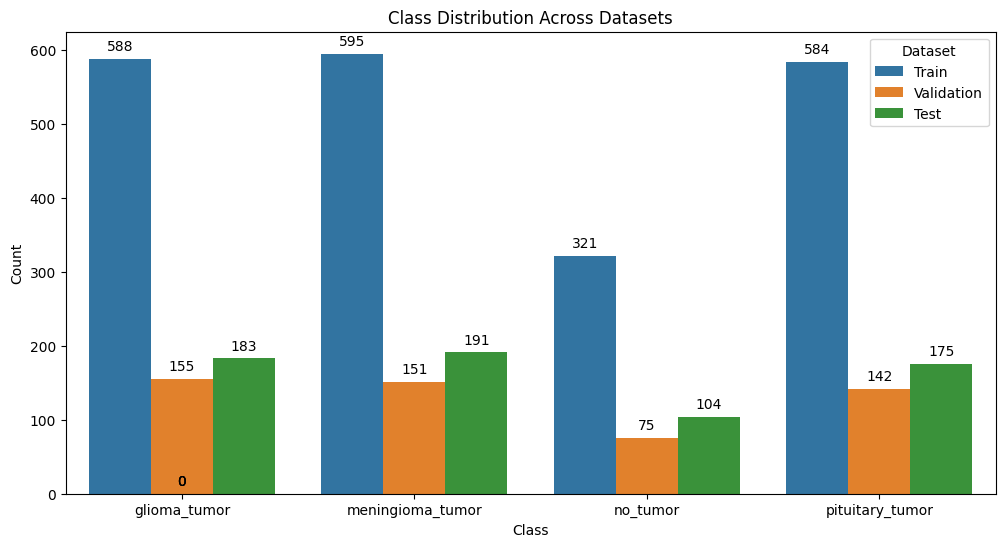

In [11]:
import pandas as pd
import seaborn as sns

def load_data(base_dir, classes, image_size):
    """
    Read images, resize, and normalize them from multiple classes.
    Arguments:
        base_dir: Base directory containing subfolders 'Training' and 'Testing'.
        classes: List of class folder names.
        image_size: Tuple indicating (width, height) for resizing images.
        validation_split: Fraction of training data to be used for validation.
    Returns:
        (X_train, y_train): Training data and labels.
        (X_val, y_val): Validation data and labels.
        (X_test, y_test): Testing data and labels.
    """
    validation_split=0.2
    test_split = 0.2
    def load_from_directory(directory, label_dict):
        data = []
        labels = []
        for class_name, label in label_dict.items():
            class_dir = os.path.join(directory, class_name)
            if not os.path.isdir(class_dir):
                continue
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                image = cv2.imread(img_path)
                if image is None:
                    continue  # Skip unreadable images
                image = cv2.resize(image, dsize=image_size, interpolation=cv2.INTER_CUBIC)
                image = image / 255.0
                data.append(image)
                labels.append(label)
        return np.array(data), np.array(labels)


    # Define class labels
    class_labels = {class_name: i for i, class_name in enumerate(classes)}

    # Load  dataset
    data_dir = os.path.join(base_dir)
    X_data_full, y_data_full = load_from_directory(data_dir, class_labels)


    #Split the full  data into training , test and validation

    # Split data into training and temporary (validation + testing) sets
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_data_full, y_data_full, test_size=test_split, shuffle=True)

    # Further split the temporary set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=validation_split, shuffle=True)

    print(f'Training examples: {len(X_train)}, Validation examples: {len(X_val)}, Testing examples: {len(X_test)}')
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
    print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
    print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

    #return (X_train, y_train), (X_val, y_val), (X_test, y_test)

    # Count samples per class
    train_class_counts = pd.Series(y_train).value_counts().sort_index()
    val_class_counts = pd.Series(y_val).value_counts().sort_index()
    test_class_counts = pd.Series(y_test).value_counts().sort_index()

    train_class_counts.index = [classes[i] for i in train_class_counts.index]
    val_class_counts.index = [classes[i] for i in val_class_counts.index]
    test_class_counts.index = [classes[i] for i in test_class_counts.index]

    return (X_train, y_train, train_class_counts), (X_val, y_val, val_class_counts), (X_test, y_test, test_class_counts)


def plot_class_distribution(train_counts, val_counts, test_counts):
    # Combine counts into a DataFrame
    df = pd.DataFrame({
        'Train': train_counts,
        'Validation': val_counts,
        'Test': test_counts
    }).reset_index().melt(id_vars='index', var_name='Dataset', value_name='Count')

    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(data=df, x='index', y='Count', hue='Dataset')
    plt.title('Class Distribution Across Datasets')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend(title='Dataset')

    # Annotate each bar with the count
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'center',
                         xytext = (0, 9),
                         textcoords = 'offset points')

    plt.show()

# Example usage:
base_dir = '/content/Dataset'
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]  # replace with your actual class names
image_size = (128, 128)  # replace with your actual image size

(X_train, y_train, train_class_counts), (X_val, y_val, val_class_counts), (X_test, y_test, test_class_counts) = load_data(base_dir, classes, image_size)

plot_class_distribution(train_class_counts, val_class_counts, test_class_counts)



#### Data Augmentation

In [12]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image  # Import this to use the Image class
import numpy as np

# Custom Dataset Class for DataLoader
class ArrayDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Arguments:
            data: Numpy array of images.
            labels: Numpy array of corresponding labels.
            transform: PyTorch transformations to apply.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert NumPy image data to PIL Image for transformation
        # Ensure that the input image is a NumPy array of shape (height, width, channels)
        image_array = (self.data[idx] * 255).astype(np.uint8)
        image = Image.fromarray(image_array)

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Tranformations
common_transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

train_data = ArrayDataset(X_train, y_train, transform=common_transforms)
val_data = ArrayDataset(X_val, y_val, transform=common_transforms)
test_data = ArrayDataset(X_test, y_test, transform=common_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Example loop to show how to iterate through the training data
for batch_images, batch_labels in train_loader:
    print(f"Batch images shape: {batch_images.shape}")
    print(f"Batch labels: {batch_labels}")


Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels: tensor([1, 2, 1, 3, 1, 3, 1, 2, 3, 1, 3, 3, 1, 0, 3, 0, 3, 2, 3, 0, 0, 1, 3, 0,
        0, 3, 0, 2, 3, 0, 2, 3])
Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels: tensor([1, 1, 3, 0, 2, 1, 2, 3, 3, 2, 3, 0, 0, 2, 0, 2, 1, 1, 0, 2, 3, 3, 3, 3,
        3, 1, 0, 3, 1, 0, 3, 3])
Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels: tensor([1, 0, 3, 1, 0, 2, 3, 3, 0, 1, 2, 1, 1, 1, 1, 3, 3, 1, 1, 2, 1, 0, 2, 3,
        2, 3, 1, 0, 1, 1, 1, 2])
Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels: tensor([3, 2, 1, 1, 3, 3, 2, 0, 3, 3, 3, 2, 3, 0, 0, 0, 0, 3, 0, 2, 0, 3, 0, 1,
        3, 3, 0, 0, 3, 1, 2, 1])
Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels: tensor([3, 0, 0, 0, 2, 3, 3, 1, 2, 2, 3, 0, 1, 3, 0, 1, 3, 1, 0, 0, 0, 2, 0, 3,
        3, 0, 0, 2, 1, 3, 0, 0])
Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels: tensor([1, 0, 0, 1, 2, 1, 0, 3, 1, 3, 0, 2, 3, 3, 0

### Display Samples

In [13]:
# Mapping class indices to class names
class_to_name = {
    0: "glioma_tumor",
    1: "meningioma_tumor",
    2: "no_tumor",
    3: "pituitary_tumor"
}

# Function to plot a grid of images
def plot_images_from_loader(data_loader, class_to_name, num_images=16, title="Dataset Samples"):
    """
    Displays a grid of images with their corresponding class labels.
    Arguments:
        data_loader: DataLoader object for the dataset to be visualized.
        class_to_name: Dictionary mapping class indices to class names.
        num_images: Number of images to display in the grid.
        title: Title of the plot.
    """
    # Determine grid size
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = rows

    # Create the figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)

    # Iterate through the data loader to get a batch
    images_shown = 0
    for images, labels in data_loader:
        for i in range(min(num_images - images_shown, len(images))):
            ax = axes[images_shown // cols, images_shown % cols]
            image = images[i].permute(1, 2, 0).numpy()
            label = labels[i].item()
            class_name = class_to_name.get(label, "Unknown")

            ax.imshow(image)
            ax.set_title(class_name)
            ax.axis("off")
            images_shown += 1

        # Break the loop once the required number of images are displayed
        if images_shown >= num_images:
            break

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
# Assuming `train_loader` and `val_loader` are the DataLoader objects defined in the previous code:
plot_images_from_loader(train_loader, class_to_name, num_images=16, title="Training Samples")
plot_images_from_loader(val_loader, class_to_name, num_images=16, title="Validation Samples")
plot_images_from_loader(test_loader, class_to_name, num_images=16, title="Test Samples")


Output hidden; open in https://colab.research.google.com to view.

### Convolutional Neural Network

In [14]:
class CNN_NO_PREPROCESSING2Layers(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_NO_PREPROCESSING2Layers, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU(inplace=True)
        self.drop1 = nn.Dropout2d(0.3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 64


        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU(inplace=True)
        self.drop2 = nn.Dropout2d(0.5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 32


        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 32 * 32, 1024)
        self.act3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 512)
        self.act4 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        # First Convolutional Layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.pool1(x)

        # Second Convolutional Layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.drop2(x)
        x = self.pool2(x)

        # Flatten before the fully connected layers
        x = torch.flatten(x, 1)

        # Fully Connected Layers
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# Create the model and move to the device
model = CNN_NO_PREPROCESSING2Layers(num_classes=4).to(device)


### Loss function and optimizer

In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.000001) # Weight_decay To keep the weights small and avoid exploding gradient.

### Train the Neural Network

In [17]:
num_epochs = 100

train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

for epoch in range(num_epochs):

    # Compute Training loss and Accuracy
    model.train()

    # initialize training accuracy and loss to 0
    train_loss = 0
    train_accuracy = 0

    for i, (images, labels) in enumerate(train_loader):
        #  GPU - move data and labels to the device
        images = images.to(device)
        labels = labels.to(device).long()  # Convert labels to torch.int64

        # Zero the gradient to prevent overly large weights
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update training loss and accuracy
        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)

        train_accuracy += int(torch.sum(prediction == labels.data))

    # Normalize training losses and accuracies
    train_loss = train_loss / len(X_train)
    train_accuracy = train_accuracy / len(X_train)

    # Append losses and accuracies of each batch to list
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Compute Validation Loss and Accuracy
    model.eval()

    # Initialize validation accuracy and loss to 0
    val_loss = 0
    val_accuracy = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            # Move data and labels to the device
            images = images.to(device)
            labels = labels.to(device).long()  # Convert labels to torch.int64

            outputs = model(images)
            v_loss = loss_function(outputs, labels)

            # Update validation loss and accuracy
            val_loss += v_loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)

            val_accuracy += int(torch.sum(prediction == labels.data))

    # Normalize validation losses and accuracies
    val_loss = val_loss / len(X_val)
    val_accuracy = val_accuracy / len(X_val)

    # Append losses and accuracies to lists
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print Train loss, Train accuracy, Validation loss, and Validation accuracy for each epoch
    print(f'Epoch: {epoch} Train Loss: {float(train_loss)} Train Accuracy: {train_accuracy * 100:.2f}% '
          f'Validation Loss: {float(val_loss)} Validation Accuracy: {val_accuracy * 100:.2f}%')

# Save the model
torch.save(model.state_dict(), 'CNN_NO_PREPROCESSING2Layers_no_preprocessing&augmentation.pth')


Epoch: 0 Train Loss: 0.6292134523391724 Train Accuracy: 73.23% Validation Loss: 0.5807375907897949 Validation Accuracy: 77.06%
Epoch: 1 Train Loss: 0.562142014503479 Train Accuracy: 77.44% Validation Loss: 0.5497968196868896 Validation Accuracy: 78.59%
Epoch: 2 Train Loss: 0.48626449704170227 Train Accuracy: 80.27% Validation Loss: 0.5217679738998413 Validation Accuracy: 78.59%
Epoch: 3 Train Loss: 0.4258282482624054 Train Accuracy: 82.42% Validation Loss: 0.514406681060791 Validation Accuracy: 81.07%
Epoch: 4 Train Loss: 0.3745364248752594 Train Accuracy: 85.15% Validation Loss: 0.44495248794555664 Validation Accuracy: 83.56%
Epoch: 5 Train Loss: 0.30900833010673523 Train Accuracy: 88.41% Validation Loss: 0.48933669924736023 Validation Accuracy: 80.50%
Epoch: 6 Train Loss: 0.286584734916687 Train Accuracy: 88.70% Validation Loss: 0.4219883680343628 Validation Accuracy: 86.04%
Epoch: 7 Train Loss: 0.24991671741008759 Train Accuracy: 90.42% Validation Loss: 0.41712048649787903 Validatio

### Plotting the Losses

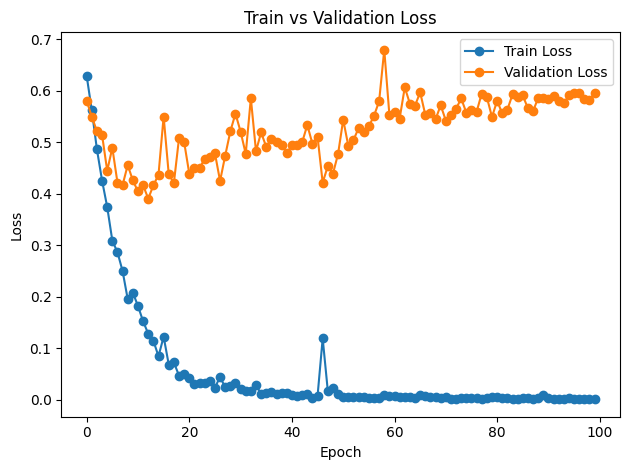

In [18]:
# Plotting the training and validation losses
plt.plot(train_losses, '-o', label='Train Loss')
plt.plot(val_losses, '-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')  # Correctly label this as 'Loss' instead of 'Accuracy'
plt.legend()
plt.title('Train vs Validation Loss')

# display the plot
plt.tight_layout()
plt.show()

### Plotting the Accuracy

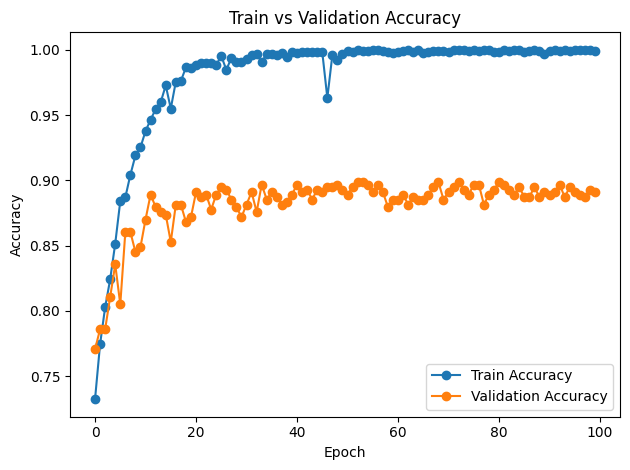

In [19]:
# Plotting the training and validation accuracies
plt.plot(train_accuracies, '-o', label='Train Accuracy')
plt.plot(val_accuracies, '-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')

# Show the plot
plt.tight_layout()
plt.show()

### Test Dataset Evaluation

In [20]:
# Initialize test loss and accuracy
test_loss = 0
test_accuracy = 0

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation since we're only evaluating
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the appropriate device
        images = images.to(device)
        labels = labels.to(device).long()

        # Get model predictions
        outputs = model(images)

        # Calculate loss
        loss = loss_function(outputs, labels)

        # Update test loss
        test_loss += loss.cpu().data * images.size(0)

        # Get predictions and compare to true labels
        _, predictions = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(predictions == labels.data))

# Normalize test loss and accuracy
test_loss = test_loss / len(X_test)
test_accuracy = test_accuracy / len(X_test)

# Print results
print(f'Test Loss: {float(test_loss)}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Loss: 0.46769773960113525
Test Accuracy: 91.58%


### Evaluation with Other Metrics

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Initialize lists to hold all true and predicted labels
true_labels = []
predicted_labels = []

# Ensure the model is in evaluation mode
model.eval()

# Collect all predictions and true labels
with torch.no_grad():
    for images, labels in test_loader:  # Adjust test_loader to your actual DataLoader
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Append the predictions and labels to lists
        predicted_labels.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=classes)
print("Classification Report:")
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate specificity for each class
def calculate_specificity(conf_matrix):
    """ Calculate specificity given a confusion matrix """
    specificity_scores = []
    for i in range(len(conf_matrix)):
        true_negatives = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
        false_positives = conf_matrix[:, i].sum() - conf_matrix[i, i]
        specificity = true_negatives / (true_negatives + false_positives)
        specificity_scores.append(specificity)
    return specificity_scores

specificity_scores = calculate_specificity(conf_matrix)

# Print specificity scores for each class
for i, score in enumerate(specificity_scores):
    print(f"Specificity for class {classes[i]}: {score:.2f}")


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.90      0.91       183
meningioma_tumor       0.90      0.91      0.90       191
        no_tumor       0.89      0.83      0.86       104
 pituitary_tumor       0.95      0.99      0.97       175

        accuracy                           0.92       653
       macro avg       0.91      0.91      0.91       653
    weighted avg       0.92      0.92      0.92       653

Specificity for class glioma_tumor: 0.97
Specificity for class meningioma_tumor: 0.96
Specificity for class no_tumor: 0.98
Specificity for class pituitary_tumor: 0.98


## Classification Report with Seaborn

Classification Report:
{'glioma_tumor': {'precision': 0.9166666666666666, 'recall': 0.9016393442622951, 'f1-score': 0.9090909090909091, 'support': 183}, 'meningioma_tumor': {'precision': 0.8963730569948186, 'recall': 0.9057591623036649, 'f1-score': 0.9010416666666666, 'support': 191}, 'no_tumor': {'precision': 0.8865979381443299, 'recall': 0.8269230769230769, 'f1-score': 0.8557213930348259, 'support': 104}, 'pituitary_tumor': {'precision': 0.9508196721311475, 'recall': 0.9942857142857143, 'f1-score': 0.9720670391061452, 'support': 175}, 'accuracy': 0.9157733537519143, 'macro avg': {'precision': 0.9126143334842407, 'recall': 0.9071518244436877, 'f1-score': 0.9094802519746368, 'support': 653}, 'weighted avg': {'precision': 0.9150947658131262, 'recall': 0.9157733537519143, 'f1-score': 0.9151138612805007, 'support': 653}}
Specificity for class glioma_tumor: 0.97
Specificity for class meningioma_tumor: 0.96
Specificity for class no_tumor: 0.98
Specificity for class pituitary_tumor: 0.98


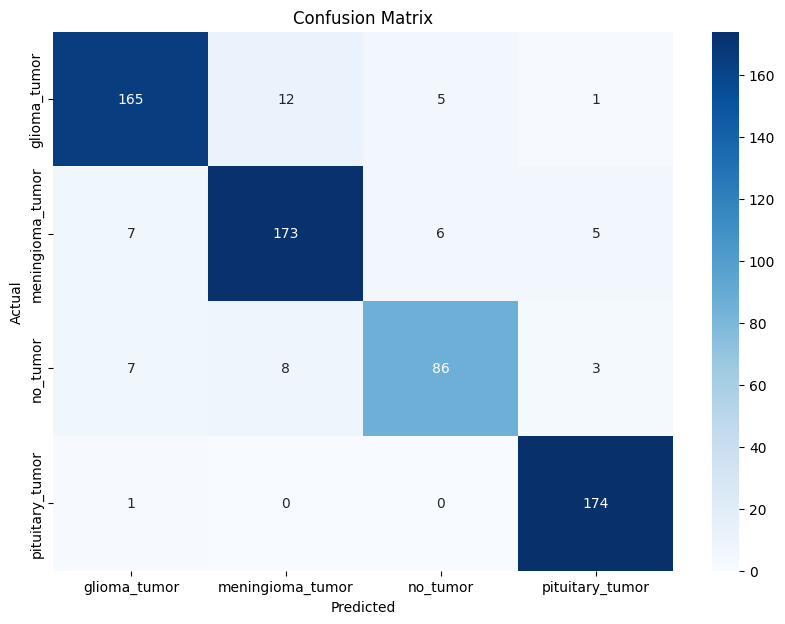

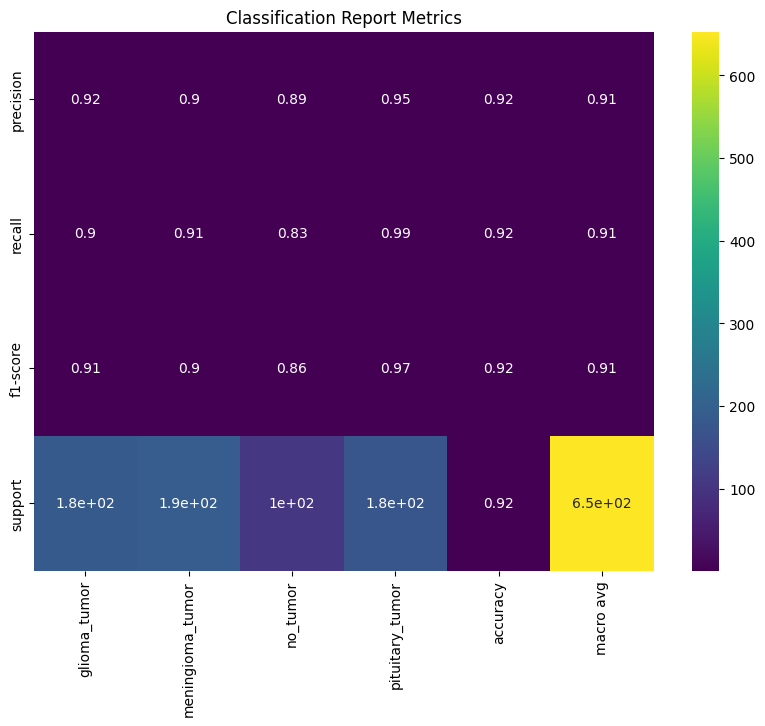

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have already computed true_labels and predicted_labels
# Initialize lists to hold all true and predicted labels
true_labels = []
predicted_labels = []

# Ensure the model is in evaluation mode
model.eval()

# Collect all predictions and true labels
with torch.no_grad():
    for images, labels in test_loader:  # Adjust test_loader to your actual DataLoader
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Append the predictions and labels to lists
        predicted_labels.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=classes, output_dict=True)
print("Classification Report:")
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate specificity for each class
def calculate_specificity(conf_matrix):
    """ Calculate specificity given a confusion matrix """
    specificity_scores = []
    for i in range(len(conf_matrix)):
        true_negatives = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
        false_positives = conf_matrix[:, i].sum() - conf_matrix[i, i]
        specificity = true_negatives / (true_negatives + false_positives)
        specificity_scores.append(specificity)
    return specificity_scores

specificity_scores = calculate_specificity(conf_matrix)

# Print specificity scores for each class
for i, score in enumerate(specificity_scores):
    print(f"Specificity for class {classes[i]}: {score:.2f}")

# Convert the confusion matrix to a DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot the classification report metrics
plt.figure(figsize=(10, 7))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='viridis')
plt.title('Classification Report Metrics')
plt.show()


### Predictions with Test Dataset